In [1]:
from hadronization import Hadronization

In [2]:
import numpy as np
from tqdm import tqdm

In [3]:
def sphericity(event):
    """
    Compute the sphericity of the hadronization event
    """
    Sab = np.zeros((4, 4))
    denom = 0.0
    P2MIN = 0.0001
    
    for i in range(len(event)):
        p_i = event[i][:3]
        p_i_p_i = np.dot(p_i, p_i)
        pWeight = 1.0 / np.sqrt(max(P2MIN, p_i_p_i))


        for j in range(1, 4):
            for k in range(j, 4):
                Sab[j][k] += pWeight * p_i[j - 1] * p_i[k - 1]

        denom += pWeight * p_i_p_i

    Sab[1:, 1:] /= denom

    # Eigenvalue computation using NumPy
    eigenvalues, eigenvectors = np.linalg.eig(Sab[1:, 1:])
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]

    return (3./2.) * (eigenvalues[0] + eigenvalues[1])

In [4]:
def thrust(event):
    # Initial values and counters
    eVal1 = 0.
    nStudy = 0.
    pOrder = []
    pSum = np.array([0., 0., 0., 0.])
    pMax = np.array([0., 0., 0., 0.])
    NSTUDYMIN = 2

    # Loop over particles in the event.
    for hadron in event:
        nStudy += 1

        # Store momenta. Use energy component for absolute momentum.
        pNow = hadron
        pNow[3] = np.linalg.norm(pNow[:3])  # Using norm for absolute momentum
        pSum += pNow
        pOrder.append(pNow)

    # Check for very low multiplicities
    if nStudy < NSTUDYMIN:
        return 0.

    # Try all combinations of reference vector orthogonal to two particles.
    for i1 in range(int(nStudy - 1)):
        for i2 in range(i1 + 1, int(nStudy)):
            nRef = np.cross(pOrder[i1][:3], pOrder[i2][:3])
            nRef = nRef / np.linalg.norm(nRef)
            pPart = np.array([0., 0., 0., 0.])

            # Add all momenta with sign; two choices for each reference particle.
            for i in range(int(nStudy)):
                if i != i1 and i != i2:
                    if np.dot(pOrder[i][:3], nRef) > 0:
                        pPart += pOrder[i]
                    else:
                        pPart -= pOrder[i]

            for j in range(4):
                if j == 0:
                    pFull = pPart + pOrder[i1] + pOrder[i2]
                elif j == 1:
                    pFull = pPart + pOrder[i1] - pOrder[i2]
                elif j == 2:
                    pFull = pPart - pOrder[i1] + pOrder[i2]
                else:
                    pFull = pPart - pOrder[i1] - pOrder[i2]
                
                pFull[3] = np.linalg.norm(pFull[:3])
                if pFull[3] > pMax[3]:
                    pMax = pFull

    # Calculate thrust
    thrust = pMax[3] / pSum[3]

    return 1. - thrust

In [21]:
# Generate simualted events
hadronization_sim = Hadronization(a = 0.68, b = 0.98, sigma = 0.335, over_sample_factor = 15)
N_events = int(1e5)
events_sim = {'z_accept_reject': [], 'mT': [], 'sphericity': [], 'multiplicity': [], 'thrust': []}
mult_buffer, accept_reject_buffer = 0,0

for i in tqdm(range(N_events)):
    had_name_list, had_p_list, had_pid_list, endC_p_list, z_accept_reject_list, mT_list = hadronization_sim.fragmentation_chain(100.0, E_threshold = 5.)
    events_sim['multiplicity'].append(len(had_name_list))
    events_sim['z_accept_reject'].append(z_accept_reject_list)
    events_sim['sphericity'].append(sphericity(had_p_list))
    events_sim['mT'].append(mT_list)
    events_sim['thrust'].append(thrust(had_p_list))

    # Track mutliplicity/accepct-reject buffer length
    if i == 0:
        mult_buffer = len(had_name_list)
        for j in range(len(z_accept_reject_list)):
            if j == 0:
                accept_reject_buffer = len(z_accept_reject_list[j])
            elif accept_reject_buffer < len(z_accept_reject_list[j]):
                accept_reject_buffer = len(z_accept_reject_list[j])
    else:
        if mult_buffer < len(z_accept_reject_list): mult_buffer = len(had_name_list)
        for j in range(len(z_accept_reject_list)):
            if accept_reject_buffer < len(z_accept_reject_list[j]):
                accept_reject_buffer = len(z_accept_reject_list[j])

 24%|██████████████████▉                                                             | 23654/100000 [01:23<04:28, 284.50it/s]


KeyboardInterrupt: 

In [ ]:
print('Max multiplicity', mult_buffer)
print('Max rejections', accept_reject_buffer)

In [ ]:
# Zero pad the relevant arrays
for i in range(len(events_sim['z_accept_reject'])):
    # Pad from the inside out
    for j in range(len(events_sim['z_accept_reject'][i])):
        events_sim['z_accept_reject'][i][j] = np.pad(events_sim['z_accept_reject'][i][j], (0, accept_reject_buffer - len(events_sim['z_accept_reject'][i][j])))
    events_sim['z_accept_reject'][i] = np.pad(events_sim['z_accept_reject'][i], [(0, mult_buffer - len(events_sim['z_accept_reject'][i])),(0,0)])
events_sim['z_accept_reject'] = np.array(events_sim['z_accept_reject'])

# Zero pad the transverse momentum 
for i in range(len(events_sim['mT'])):
    events_sim['mT'][i] = np.pad(events_sim['mT'][i], (0, mult_buffer - len(events_sim['mT'][i])))     
events_sim['mT'] = np.array(events_sim['mT'])

In [ ]:
print(events_sim['z_accept_reject'].shape)
print(events_sim['mT'].shape)

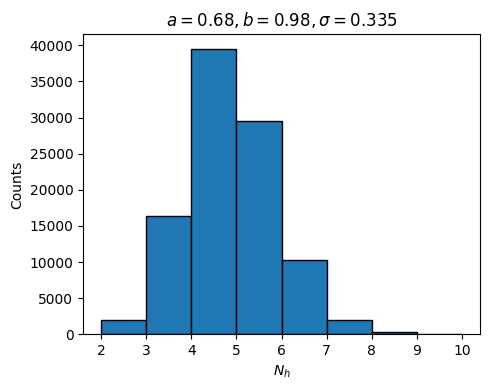

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,4))
max_sim = np.max(events_sim['multiplicity'])
min_sim = np.min(events_sim['multiplicity'])
ax.hist(events_sim['multiplicity'], max_sim - min_sim, edgecolor='black')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$N_h$')
ax.set_title(r'$a = 0.68, b = 0.98, \sigma = 0.335$')
fig.tight_layout()

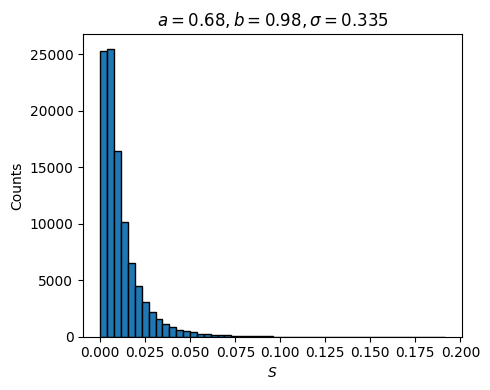

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.hist(events_sim['sphericity'], 50, edgecolor='black')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$S$')
ax.set_title(r'$a = 0.68, b = 0.98, \sigma = 0.335$')
fig.tight_layout()

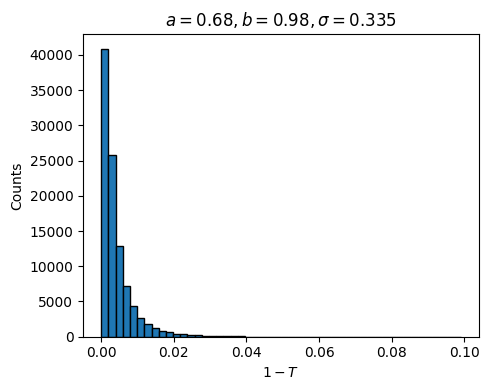

In [11]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.hist(events_sim['thrust'], 50, edgecolor='black')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$1-T$')
ax.set_title(r'$a = 0.68, b = 0.98, \sigma = 0.335$')
fig.tight_layout()

In [13]:
# Generate 'experimental' events
hadronization_exp = Hadronization(a = 0.8, b = 1.2, sigma = 0.335, over_sample_factor = 15.)
N_events = int(1e5)
# Define 'experimental' dictionary to hold relevant info
events_exp = {'sphericity': [], 'multiplicity': [], 'thrust': []}

for i in tqdm(range(N_events)):
    had_name_list, had_p_list, had_pid_list, endC_p_list, z_accept_reject_list, mT = hadronization_exp.fragmentation_chain(100.0, E_threshold = 5.)
    events_exp['multiplicity'].append(len(had_name_list))
    events_exp['sphericity'].append(sphericity(had_p_list))
    events_exp['thrust'].append(thrust(had_p_list))

100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:46<00:00, 288.66it/s]


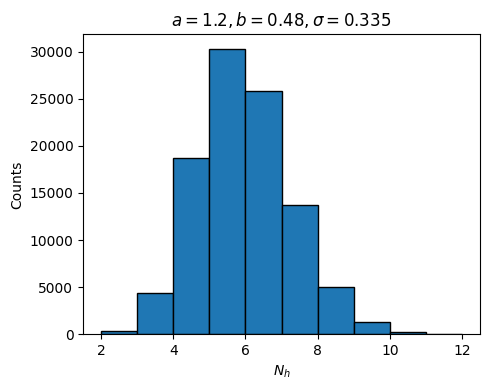

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,4))
max_exp = np.max(events_exp['multiplicity'])
min_exp = np.min(events_exp['multiplicity'])
ax.hist(events_exp['multiplicity'], max_exp - min_exp, edgecolor='black')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$N_h$')
ax.set_title(r'$a = 1.2, b = 0.48, \sigma = 0.335$')
fig.tight_layout()

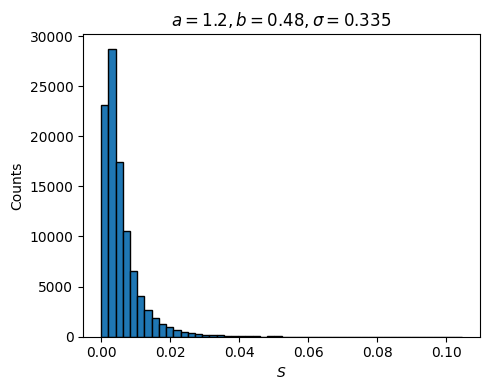

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.hist(events_exp['sphericity'], 50, edgecolor='black')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$S$')
ax.set_title(r'$a = 1.2, b = 0.48, \sigma = 0.335$')
fig.tight_layout()

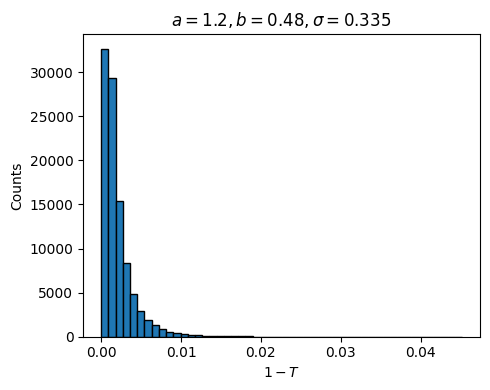

In [16]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.hist(events_exp['thrust'], 50, edgecolor='black')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$1-T$')
ax.set_title(r'$a = 1.2, b = 0.48, \sigma = 0.335$')
fig.tight_layout()

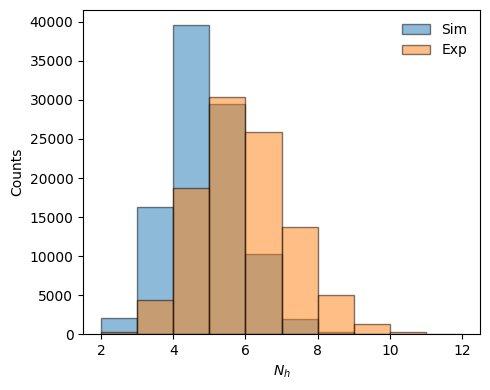

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
max_exp = np.max(events_exp['multiplicity'])
min_exp = np.min(events_exp['multiplicity'])
max_sim = np.max(events_sim['multiplicity'])
min_sim = np.min(events_sim['multiplicity'])
ax.hist(events_sim['multiplicity'], max_sim - min_sim, edgecolor='black', alpha = 0.5, label='Sim')
ax.hist(events_exp['multiplicity'], max_exp - min_exp, edgecolor='black', alpha = 0.5, label='Exp')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$N_h$')
ax.legend(frameon=False)
#ax.set_title(r'$a = 0.68, b = 0.98, \sigma = 0.33$')
fig.tight_layout()

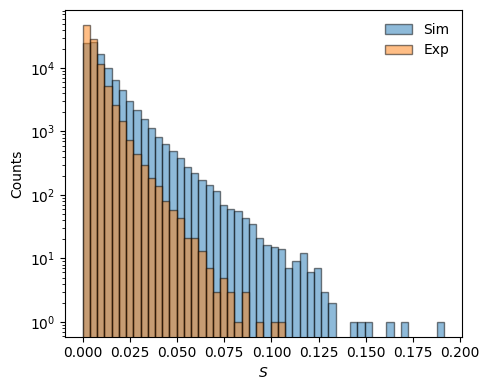

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
bins=np.histogram(np.hstack((events_sim['sphericity'], events_exp['sphericity'])), bins=50)[1]
ax.hist(events_sim['sphericity'], bins, edgecolor='black', alpha = 0.5, label='Sim')
ax.hist(events_exp['sphericity'], bins, edgecolor='black', alpha = 0.5, label='Exp')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$S$')
ax.legend(frameon=False)
ax.set_yscale('log')
#ax.set_title(r'$a = 0.68, b = 0.98, \sigma = 0.33$')
fig.tight_layout()

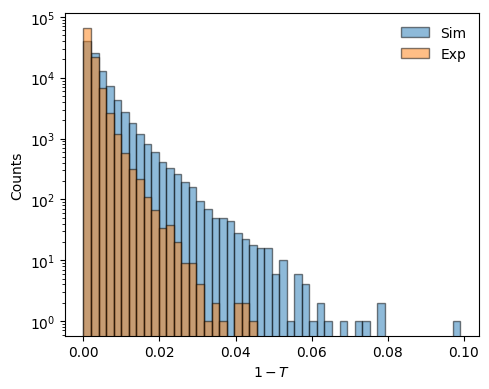

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
bins=np.histogram(np.hstack((events_sim['thrust'], events_exp['thrust'])), bins=50)[1]
ax.hist(events_sim['thrust'], bins, edgecolor='black', alpha = 0.5, label='Sim')
ax.hist(events_exp['thrust'], bins, edgecolor='black', alpha = 0.5, label='Exp')
ax.set_ylabel(r'Counts')
ax.set_xlabel(r'$1-T$')
ax.legend(frameon=False)
ax.set_yscale('log')
#ax.set_title(r'$a = 0.68, b = 0.98, \sigma = 0.33$')
fig.tight_layout()

In [ ]:
# Save the sim data
np.save('sim_events_dict_a_0.68_b_0.98_sigma_0.335.npy', events_sim)

In [17]:
# Save the exp data
np.save('exp_observables_dict_a_0.8_b_1.2_sigma_0.335.npy', events_exp)

In [65]:
# Load the data
exp = np.load('exp_observables_dict_a_1.2_b_0.48_sigma_0.335.npy', allow_pickle = True).item()